In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import aquarel as aq
from ineqpy.inequality import gini
import scipy.stats as st
import pyalex as alex
alex.config.email = "noah0roussel01980@gmail.com"
works = pl.read_csv("../../../data/works/works_q1.csv")
works = works.filter(pl.col("year") != 2025)

year_begin = 1920
year_end = 2024
works = works.with_columns(
    age=2025 - pl.col("year")
)




In [ ]:
cbc_per_year = (
    works
    .select(
        [pl.col("year"), pl.col("cited_by_count"), pl.col("title")]
    )
    .group_by(
        pl.col("year"),
        maintain_order=True
    )
    .agg(
        pl.col("cited_by_count").mean().name.prefix("mean_")
    )
) # number of citations (cbc = cited by count) of the works published a given year

works = works.join(
    cbc_per_year,
    on="year",
    how="left"
) # left join

works = (
    works
    .with_columns(
        mncs = pl.col("cited_by_count") / pl.col("mean_cited_by_count")
    )
    .drop("mean_cited_by_count")
)
cols_authors = [col for col in works.columns if col.startswith("author_")]

works = works.with_columns(
    authors_count = sum(
        [pl.col(col).is_not_null().cast(pl.Int8) for col in cols_authors]
    )

)

works = works.with_columns(
    title = pl.col("title").fill_null("").str.to_lowercase(),
    abstract = pl.col("abstract").fill_null("").str.to_lowercase()
)

works = works.with_columns(
    review = (
        pl.col("title").str.contains("review") |
        pl.col("abstract").str.contains("review")
    ),
    meta_analysis = (
        pl.col("title").str.contains("meta[\u00AD-]?analysis") |
        pl.col("abstract").str.contains("meta[\u00AD-]?analysis")
    )
)

works = works.with_columns([
    pl.when(pl.col("countries_distinct_count").is_null() | pl.col("countries_distinct_count").is_nan() | (pl.col("countries_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("countries_distinct_count"))
      .alias("countries_distinct_count")
])
works = works.with_columns([
    pl.when(pl.col("institutions_distinct_count").is_null() | pl.col("institutions_distinct_count").is_nan() | (pl.col("institutions_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("institutions_distinct_count"))
      .alias("institutions_distinct_count")
])

group_year_mean = (
    works.group_by(
        by= pl.col("year"),
        maintain_order=True 
        )
        .mean()
        .select(
            ["year", "cited_by_count", "countries_distinct_count", "institutions_distinct_count", "referenced_works_count", "authors_count", "mncs"]
        )
)

group_year_mean = (
    works.group_by(
        by= pl.col("year"),
        maintain_order=True 
        )
        .mean()
        .select(
            ["year", "cited_by_count", "countries_distinct_count", "institutions_distinct_count", "referenced_works_count", "authors_count", "mncs"]
        )
)

group_year_mean = group_year_mean.sort(by="year", descending=True)
group_references_mean = (
    works.lazy() 
    .filter(~pl.col("review") & ~pl.col("meta_analysis"))
    .group_by("referenced_works_count")
    .agg([
        pl.col("mncs").mean().alias("mncs"),
        pl.len().alias("count")
    ])
    .sort("referenced_works_count")
    .collect()  
)

works

title,year,cited_by_count,countries_distinct_count,institutions_distinct_count,citation_normalized_percentile,primary_topic,keywords,concepts,referenced_works_count,referenced_works,abstract,abstract_inverted_index,journal,author_1,author_2,author_3,institution_1,institution_2,institution_3,country_1,country_2,country_3,cited_by_count_2025,cited_by_count_2024,cited_by_count_2023,cited_by_count_2022,cited_by_count_2021,cited_by_count_2020,cited_by_count_2019,cited_by_count_2018,cited_by_count_2017,cited_by_count_2016,cited_by_count_2015,cited_by_count_2014,cited_by_count_2013,cited_by_count_2012,…,country_239,country_240,country_241,country_242,country_243,country_244,country_245,country_246,country_247,country_248,country_249,country_250,country_251,country_252,country_253,country_254,country_255,country_256,country_257,country_258,country_259,country_260,country_261,country_262,country_263,country_264,country_265,country_266,country_267,country_268,country_269,country_270,age,mncs,authors_count,review,meta_analysis
str,i64,i64,i64,i64,str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,f64,i8,bool,bool
"""ros stress in cancer cells and…",2004,1881,1,1,"""{'value': 0.816836, 'is_in_top…","""Redox biology and oxidative st…","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",158,"""['https://openalex.org/W116540…","""""",null,"""Drug Resistance Updates""","""https://openalex.org/A50102407…","""https://openalex.org/A50076048…","""https://openalex.org/A51006444…","""['The University of Texas MD A…","""['The University of Texas MD A…","""['The University of Texas MD A…","""US""","""US""","""US""",40.0,71.0,85.0,108.0,133.0,133.0,97.0,91.0,127.0,111.0,119.0,130.0,108.0,117.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,21,35.103559,3,false,false
"""aminoglycoside modifying enzym…",2010,1294,1,1,"""{'value': 0.995475, 'is_in_top…","""Bacteriophages and microbial i…","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",336,"""['https://openalex.org/W141030…","""""",null,"""Drug Resistance Updates""","""https://openalex.org/A50909767…","""https://openalex.org/A50055229…",null,"""['California State University,…","""['California State University,…",null,"""US""","""US""",null,74.0,108.0,123.0,144.0,136.0,162.0,108.0,92.0,72.0,70.0,57.0,52.0,45.0,26.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,15,24.857588,2,false,false
"""overcoming the blood–brain tum…",2015,898,2,6,"""{'value': 0.998282, 'is_in_top…","""Glioma Diagnosis and Treatment""","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",159,"""['https://openalex.org/W148541…","""""",null,"""Drug Resistance Updates""","""https://openalex.org/A50341518…","""https://openalex.org/A50913295…","""https://openalex.org/A50395930…","""['The Netherlands Cancer Insti…","""['Amsterdam UMC Location Vrije…","""['The Netherlands Cancer Insti…","""NL""","""NL""","""NL""",80.0,87.0,97.0,110.0,116.0,119.0,91.0,80.0,59.0,43.0,15.0,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,10,23.127161,6,false,false
"""targeting the pi3k/akt/mtor pa…",2008,786,1,2,"""{'value': 0.999673, 'is_in_top…","""PI3K/AKT/mTOR signaling in can…","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",236,"""['https://openalex.org/W150966…","""""",null,"""Drug Resistance Updates""","""https://openalex.org/A50898992…","""https://openalex.org/A50296122…","""https://openalex.org/A51080787…",

In [ ]:
countries_col = [f"country_{i}" for i in range(1, 193)]

countries = (
    works
    .select(["year", "cited_by_count", "mncs", *countries_col])  
    .sort("year")
    .with_row_index("index_work")
    .unpivot(
        on=countries_col,
        index=["year", "index_work", "cited_by_count", "mncs"],
        variable_name="country_pos",
        value_name="country_name"
    )
    .filter(pl.col("country_name").is_not_null())
    .with_columns(count=pl.lit(1, dtype=pl.Int8))  
)

countries

year,index_work,cited_by_count,mncs,country_pos,country_name,count
i64,u32,i64,f64,str,str,i8
1948,4737,9,0.803571,"""country_1""","""AT""",1
1948,4740,1,0.089286,"""country_1""","""CH""",1
1955,6245,30,1.534133,"""country_1""","""DE""",1
1958,6927,373,12.49231,"""country_1""","""US""",1
1958,6928,177,5.927986,"""country_1""","""US""",1
…,…,…,…,…,…,…
2017,506649,18,0.449923,"""country_190""","""GB""",1
2015,466011,0,0.0,"""country_191""","""BE""",1
2017,506649,18,0.449923,"""country_191""","""CA""",1


In [4]:
group_countriesyears = (
    countries
    .drop("country_pos")
    .group_by(["country_name", "year"], maintain_order=True).sum()
    .sort("year")
)
group_countries = (
    countries
    .with_columns(
        age=pl.lit(2025)-pl.col("year")
    )
    .drop(["country_pos", "year"])
    .group_by(
        by="country_name",
        maintain_order=True
    )
    .agg(
        count=pl.col("count").sum(),
        mean_mncs=pl.col("mncs").mean(),
        mean_cited_by_count=pl.col("cited_by_count").mean(),
        mean_age=pl.col("age").mean()
    )
    .sort("count", descending=True)
    .rename({"by":"country_name"})
)

In [ ]:
group_countriesyears = (
    group_countriesyears
    .with_columns(
        cum_cited_by_count=pl.col("cited_by_count").cum_sum().over("country_name"),
        cum_mncs=pl.col("mncs").cum_sum().over("country_name"),
        cum_count=pl.col("count").cum_sum().over("country_name")
    ) 
    .with_columns(
        mean_mncs=pl.col("mncs")/pl.col("count"),
        mean_cum_mncs=pl.col("cum_mncs")/pl.col("cum_count")
    )
)
group_Ncountries_mean = (
    works.select(["cited_by_count", "countries_distinct_count", "mncs"])
    .group_by("countries_distinct_count")
    .mean()
) 


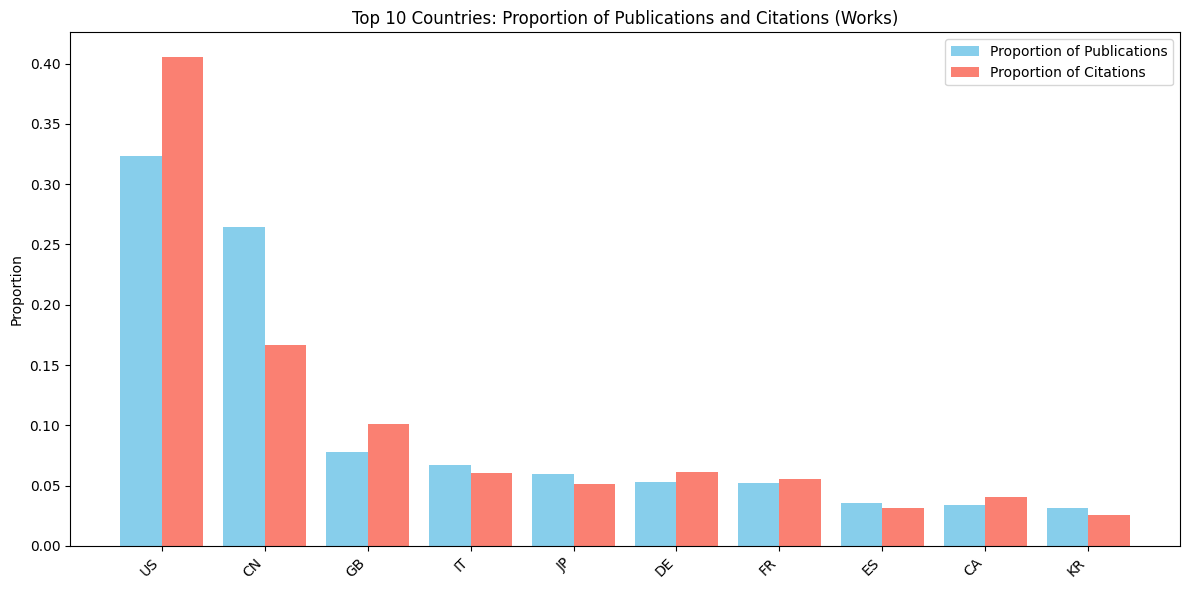

In [ ]:
top_countries = (
    group_countries.sort("count", descending=True)
                   .head(10)
                   .select("country_name")
                   .to_series()
                   .to_list()
)

df_top_countries = group_countries.filter(pl.col("country_name").is_in(top_countries)).to_pandas()
df_top_countries_years = group_countriesyears.filter(
    pl.col("country_name").is_in(top_countries)
).to_pandas()

df_top_countries["prop_publications"] = df_top_countries["count"] / df_top_countries["count"].sum()
df_top_countries["prop_citations"] = df_top_countries["mean_cited_by_count"] * df_top_countries["count"]
df_top_countries["prop_citations"] /= df_top_countries["prop_citations"].sum()

fig, ax = plt.subplots(figsize=(12, 6))

width = 0.4
countries = df_top_countries["country_name"]
x = range(len(countries))

ax.bar(x, df_top_countries["prop_publications"], width=width, label="Proportion of Publications", color="skyblue")

ax.bar([i + width for i in x], df_top_countries["prop_citations"], width=width, label="Proportion of Citations", color="salmon")

ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(countries, rotation=45, ha="right")
ax.set_ylabel("Proportion")
ax.set_title("Top 10 Countries: Proportion of Publications and Citations ")
ax.legend()
plt.tight_layout()
plt.show()

C:\Users\noahr\AppData\Local\Temp\ipykernel_17380\3916111987.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = age_countries, x = "country_name", y = "mean_age", palette = "viridis_r")


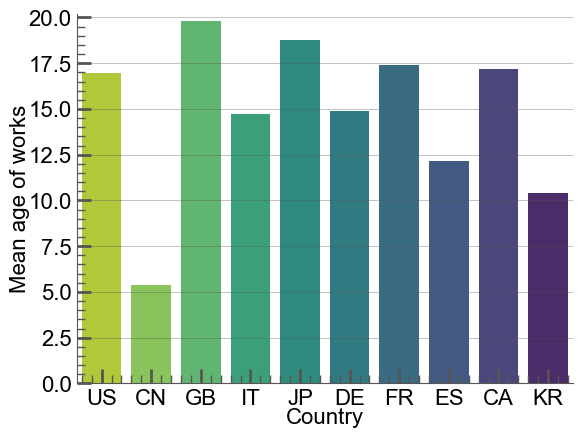

In [7]:
age_countries = (
    group_countries
    .sort("count", descending=True)
    .head(10)
)
with aq.load_theme("scientific"):
    sns.barplot(data = age_countries, x = "country_name", y = "mean_age", palette = "viridis_r")
    plt.ylabel("Mean age of works", fontsize=16)
    plt.xlabel("Country", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

<Figure size 640x480 with 0 Axes>

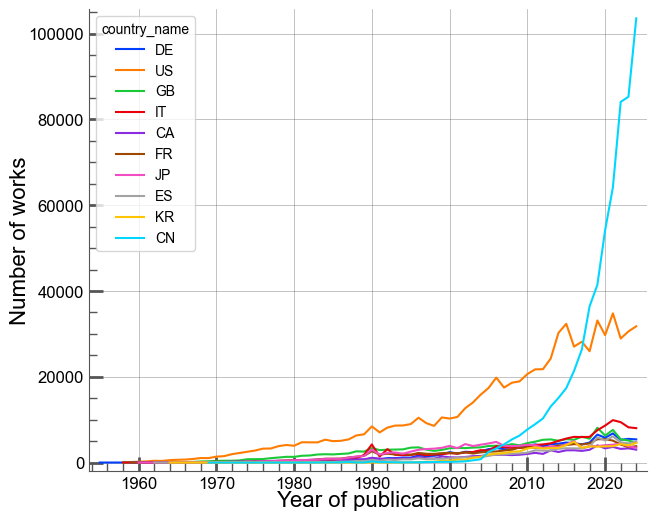

In [8]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    sns.lineplot(data = group_countriesyears.filter(pl.col("country_name").is_in(top_countries)), x = "year", y = "count", hue = "country_name", palette = "bright")
    #plt.xlim(1980, 2024)
    plt.xlabel("Year of publication", fontsize=16)
    plt.ylabel("Number of works", fontsize=16)
    plt.show()

<Figure size 640x480 with 0 Axes>

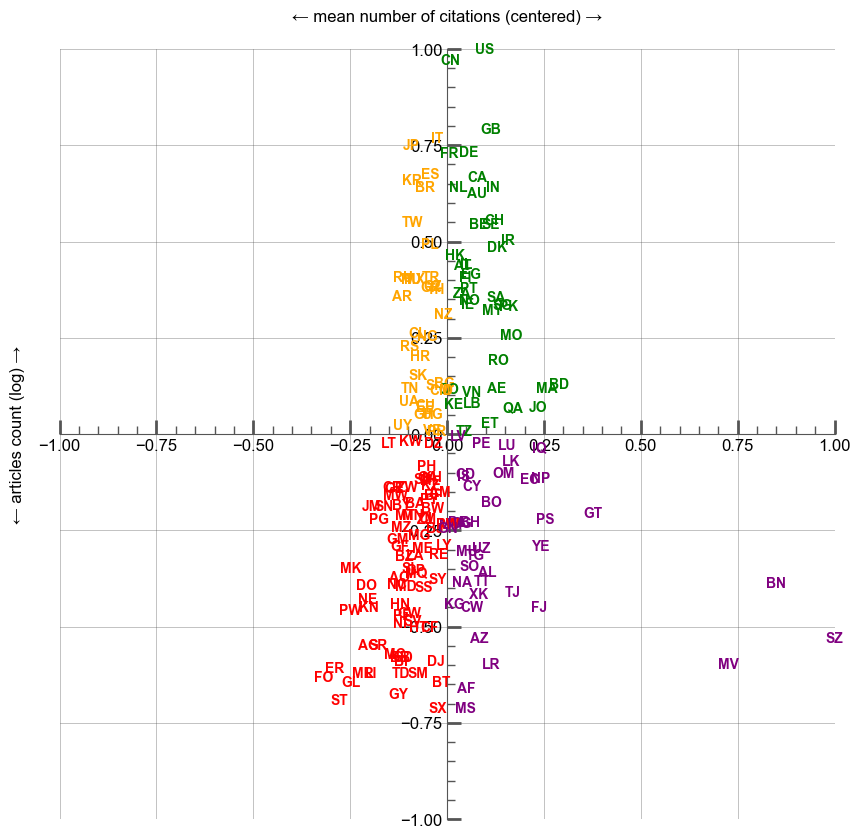

In [9]:
group_countries_filtered = group_countries.filter(pl.col("count") > 5)

group_countries_filtered = group_countries_filtered.with_columns(
    pl.col("count").log().alias("count_log")
)

mean_mncs_mean = group_countries_filtered["mean_mncs"].mean()
group_countries_filtered = group_countries_filtered.with_columns(
    (pl.col("mean_mncs") - mean_mncs_mean).alias("mean_mncs_centered")
)
count_log_max = group_countries_filtered["count_log"].max()
mean_mncs_centered_max = group_countries_filtered["mean_mncs_centered"].abs().max() 

group_countries_filtered = group_countries_filtered.with_columns([
    (-1 + 2 * pl.col("count_log") / count_log_max).alias("count_viz"),
    (pl.col("mean_mncs_centered") / mean_mncs_centered_max).alias("mean_mncs_viz")
])

country_names = group_countries_filtered["country_name"].to_list()
count_viz = group_countries_filtered["count_viz"].to_list()
mean_mncs_viz = group_countries_filtered["mean_mncs_viz"].to_list()

plt.figure(figsize=(10, 10))
for name, x, y in zip(country_names, mean_mncs_viz, count_viz):
    if y >= 0 and x >= 0:
        color = "green"
    elif y >= 0 and x < 0:
        color = "orange"
    elif y < 0 and x < 0:
        color = "red"
    else:  
        color = "purple"
    plt.text(x, y, name, ha="center", va="center", fontsize=10, fontweight="bold", color=color)

plt.xlabel("← mean number of citations (centered) →", labelpad=-320)
plt.ylabel("← articles count (log) →", labelpad=270)
plt.xlim(-1, 1)
plt.ylim(-1, 1)

ax = plt.gca()
ax.spines['left'].set_position('zero')  
ax.spines['bottom'].set_position('zero') 

plt.show()

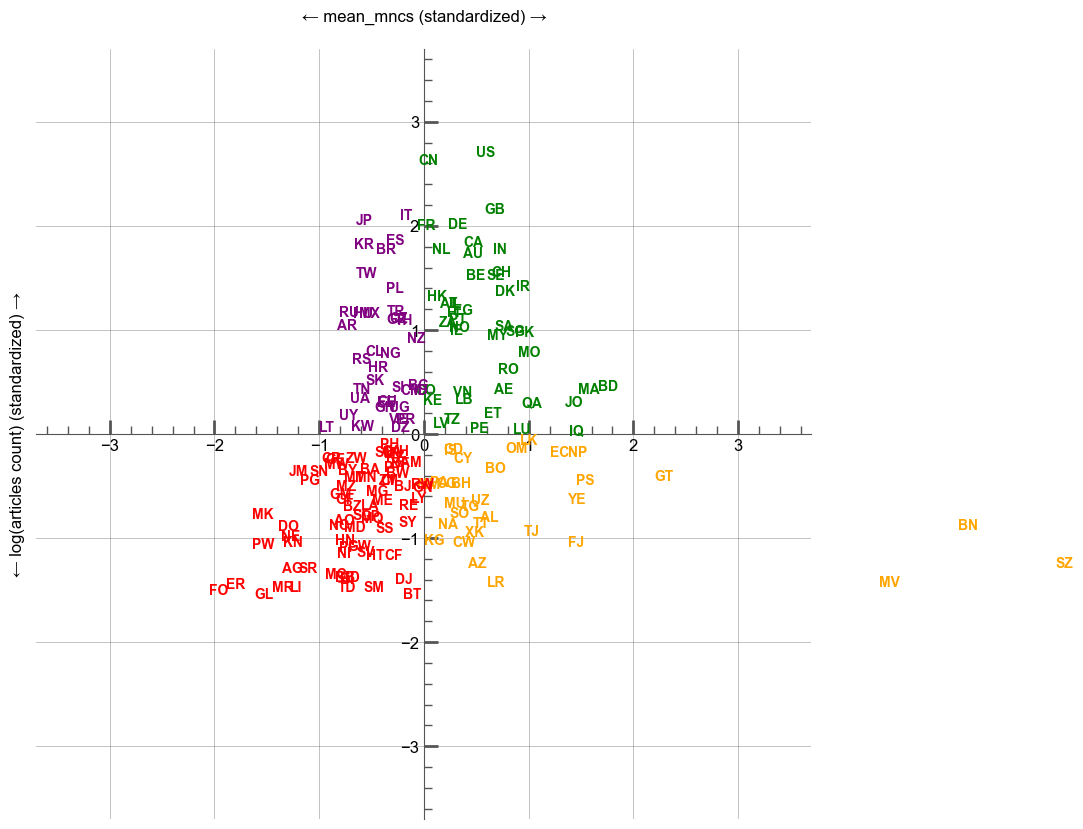

In [10]:
group_countries_filtered = group_countries.filter(pl.col("count") > 10)

group_countries_filtered = group_countries_filtered.with_columns(
    pl.col("count").log().alias("count_log")
)


mean_mncs_mean = group_countries_filtered["mean_mncs"].mean()
mean_mncs_std = group_countries_filtered["mean_mncs"].std()
count_log_mean = group_countries_filtered["count_log"].mean()
count_log_std = group_countries_filtered["count_log"].std()

group_countries_filtered = group_countries_filtered.with_columns([
    ((pl.col("mean_mncs") - mean_mncs_mean)/mean_mncs_std).alias("mean_mncs_viz"),
    ((pl.col("count_log") - count_log_mean)/count_log_std).alias("count_viz")
])


country_names = group_countries_filtered["country_name"].to_list()
mean_mncs_viz = group_countries_filtered["mean_mncs_viz"].to_list()
count_viz = group_countries_filtered["count_viz"].to_list()


plt.figure(figsize=(10, 10))
for name, x, y in zip(country_names, mean_mncs_viz, count_viz):
    if x >= 0 and y >= 0:
        color = "green"
    elif x < 0 and y >= 0:
        color = "purple"
    elif x < 0 and y < 0:
        color = "red"
    else:  
        color = "orange"
    plt.text(x, y, name, ha="center", va="center", fontsize=10, fontweight="bold", color=color)

plt.xlabel("← mean_mncs (standardized) →", labelpad=-320)
plt.ylabel("← log(articles count) (standardized) →", labelpad=270)
plt.xlim(-3.7, 3.7)
plt.ylim(-3.7, 3.7)

ax = plt.gca()
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

plt.show()

In [11]:
r_pearson, p_pearson = st.pearsonr(works["countries_distinct_count"], works["mncs"])
print(f"Pearson: r = {r_pearson:.3f}, p-value = {p_pearson:.3f}")

r_spearman, p_spearman = st.spearmanr(works["countries_distinct_count"], works["mncs"])
print(f"Spearman: rho = {r_spearman:.3f}, p-value = {p_spearman:.3f}")

Pearson: r = 0.061, p-value = 0.000
Spearman: rho = 0.148, p-value = 0.000


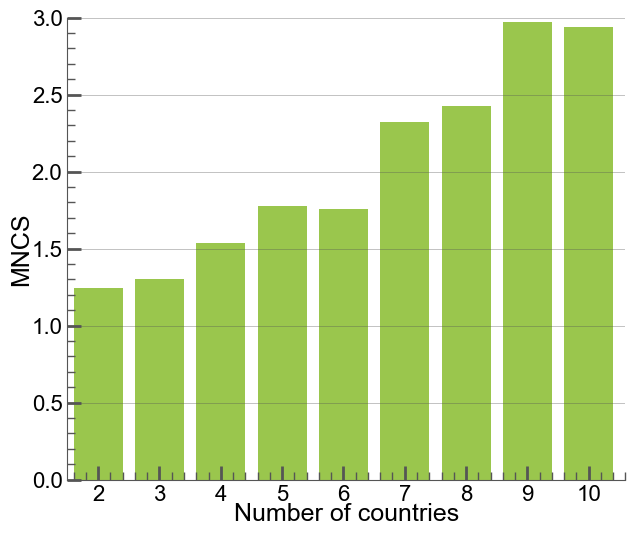

In [12]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    sns.barplot(data = group_Ncountries_mean, x = "countries_distinct_count", y = "mncs", color = sns.color_palette("viridis")[5])
    plt.xlim(0.5, 9.6)
    plt.ylim(0,3)
    # plt.xticks(rotation = 45)
    plt.xlabel("Number of countries", fontsize=18)
    plt.ylabel("MNCS", fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()